In [6]:
import os
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Set directories
sketch_dir = r"C:\Users\mdgha\OneDrive\Documents\Ghayaz Personal\Gen AI\GAN project\data\trainA"  # Directory with sketch images
real_dir = r"C:\Users\mdgha\OneDrive\Documents\Ghayaz Personal\Gen AI\GAN project\data\trainB"  # Directory with real images
img_size = (128, 128)  # Image size for resizing

def load_images(img_dir):
    """Load images from a directory, resize, and normalize."""
    images = []
    for img_name in os.listdir(img_dir):
        img_path = os.path.join(img_dir, img_name)
        img = load_img(img_path, target_size=img_size)
        img = img_to_array(img) / 255.0  # Normalize to [0, 1]
        images.append(img)
    return np.array(images)

# Load datasets
sketch_images = load_images(sketch_dir)
real_images = load_images(real_dir)

# Convert to TensorFlow datasets for training
BUFFER_SIZE = 1000
BATCH_SIZE = 1

sketch_ds = tf.data.Dataset.from_tensor_slices(sketch_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
real_ds = tf.data.Dataset.from_tensor_slices(real_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


In [7]:
from tensorflow.keras import layers, Model

def build_generator():
    """Simple generator using Conv2DTranspose."""
    inputs = layers.Input(shape=(128, 128, 3))
    x = layers.Conv2D(64, 4, strides=2, padding="same", activation="relu")(inputs)
    x = layers.Conv2D(128, 4, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2DTranspose(64, 4, strides=2, padding="same", activation="relu")(x)
    outputs = layers.Conv2DTranspose(3, 4, strides=2, padding="same", activation="tanh")(x)
    return Model(inputs, outputs)

def build_discriminator():
    """Simple discriminator using Conv2D."""
    inputs = layers.Input(shape=(128, 128, 3))
    x = layers.Conv2D(64, 4, strides=2, padding="same", activation="relu")(inputs)
    x = layers.Conv2D(128, 4, strides=2, padding="same", activation="relu")(x)
    outputs = layers.Conv2D(1, 4, strides=1, padding="same")(x)
    return Model(inputs, outputs)

# Initialize models
generator_g = build_generator()  # Sketch-to-real
generator_f = build_generator()  # Real-to-sketch
discriminator_x = build_discriminator()  # Real image discriminator
discriminator_y = build_discriminator()  # Sketch image discriminator


In [8]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real, fake):
    real_loss = loss_object(tf.ones_like(real), real)
    fake_loss = loss_object(tf.zeros_like(fake), fake)
    return real_loss + fake_loss

def generator_loss(fake):
    return loss_object(tf.ones_like(fake), fake)

# Optimizers
gen_g_optimizer = tf.keras.optimizers.Adam(0.0002, beta_1=0.5)
gen_f_optimizer = tf.keras.optimizers.Adam(0.0002, beta_1=0.5)
disc_x_optimizer = tf.keras.optimizers.Adam(0.0002, beta_1=0.5)
disc_y_optimizer = tf.keras.optimizers.Adam(0.0002, beta_1=0.5)


In [9]:
@tf.function
def train_step(real_x, real_y):
    with tf.GradientTape(persistent=True) as tape:
        # Generate fake images
        fake_y = generator_g(real_x, training=True)
        fake_x = generator_f(real_y, training=True)

        # Cycle back
        cycled_x = generator_f(fake_y, training=True)
        cycled_y = generator_g(fake_x, training=True)

        # Discriminator outputs
        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)
        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)

        # Losses
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)
        cycle_loss = tf.reduce_mean(tf.abs(real_x - cycled_x)) + tf.reduce_mean(tf.abs(real_y - cycled_y))
        total_gen_g_loss = gen_g_loss + cycle_loss
        total_gen_f_loss = gen_f_loss + cycle_loss

        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

    # Update weights
    gen_g_grads = tape.gradient(total_gen_g_loss, generator_g.trainable_variables)
    gen_f_grads = tape.gradient(total_gen_f_loss, generator_f.trainable_variables)
    disc_x_grads = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)
    disc_y_grads = tape.gradient(disc_y_loss, discriminator_y.trainable_variables)

    gen_g_optimizer.apply_gradients(zip(gen_g_grads, generator_g.trainable_variables))
    gen_f_optimizer.apply_gradients(zip(gen_f_grads, generator_f.trainable_variables))
    disc_x_optimizer.apply_gradients(zip(disc_x_grads, discriminator_x.trainable_variables))
    disc_y_optimizer.apply_gradients(zip(disc_y_grads, discriminator_y.trainable_variables))

# Training loop
EPOCHS = 10  # Set low for testing, increase for actual training

for epoch in range(EPOCHS):
    for real_x, real_y in tf.data.Dataset.zip((sketch_ds, real_ds)):
        train_step(real_x, real_y)
    print(f"Epoch {epoch + 1}/{EPOCHS} completed.")


Epoch 1/10 completed.
Epoch 2/10 completed.
Epoch 3/10 completed.
Epoch 4/10 completed.
Epoch 5/10 completed.
Epoch 6/10 completed.
Epoch 7/10 completed.
Epoch 8/10 completed.
Epoch 9/10 completed.
Epoch 10/10 completed.


In [56]:
import matplotlib.pyplot as plt

def show_images(input_image, generated_image):
    plt.figure(figsize=(6, 6))
    display_list = [input_image[0], generated_image[0]]
    titles = ["Input","Generated"]
    for i in range(2):
        plt.subplot(1, 2, i + 1)
        plt.title(titles[i])
        image_rescaled = (display_list[i] + 1) * 127.5  # Rescale to [0, 255]
        image_rescaled = np.array(image_rescaled)
# Display the image
        plt.imshow(image_rescaled.astype('uint8'))  # Rescale [-1, 1] to [0, 1]
        plt.axis("off")
    plt.show()

# Load a test sketch and generate a corresponding image



In [15]:
import cv2

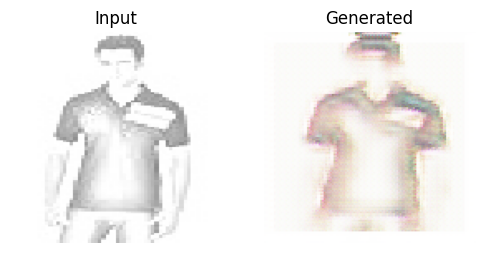

In [57]:
for test_sketch in sketch_ds.take(1):
    generated_image = generator_g(test_sketch, training=False)
    show_images(test_sketch, generated_image)

In [39]:
import numpy as np

def equalize_histogram_rgb(image):
    image = np.array(image)
    ycrcb = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
    
    # Apply histogram equalization to the Y channel (luminance)
    ycrcb[:, :, 0] = cv2.equalizeHist(ycrcb[:, :, 0])
    
    # Convert back to BGR color space
    equalized_image = cv2.cvtColor(ycrcb, cv2.COLOR_YCrCb2BGR)
    return equalized_image
    

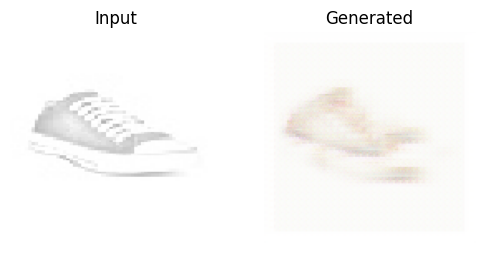

In [59]:
sketch_image = load_img(r"C:\Users\mdgha\OneDrive\Documents\Ghayaz Personal\Gen AI\GAN project\data\testA\sketch_5866.jpg", target_size=(128, 128, 3))
sketch_image = img_to_array(sketch_image) / 255.0
sketch_image = np.expand_dims(sketch_image, axis=0)

generated_image = generator_g(sketch_image, training=False)
generated_image = generated_image
#generated_image=cv2.bilateralFilter(generated_image, d=9, sigmaColor=75, sigmaSpace=75)

show_images(sketch_image, generated_image)

In [60]:
# Save models in .h5 format
generator_g.save("generator_g.h5")  # Save the Sketch-to-Real generator
generator_f.save("generator_f.h5")  # Save the Real-to-Sketch generator
discriminator_x.save("discriminator_x.h5")  # Save the Real image discriminator
discriminator_y.save("discriminator_y.h5")  # Save the Sketch image discriminator

print("Models saved successfully.")


Models saved successfully.
